<a href="https://colab.research.google.com/github/hunterwr/myrepo/blob/main/Copy_of_Mod5t2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [ ]:
#set up 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# import noise layer
from keras.layers import GaussianNoise

In [ ]:
# prep for pictures
batch_size = 64
img_height = 100
img_width = 100

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'training/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'training/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


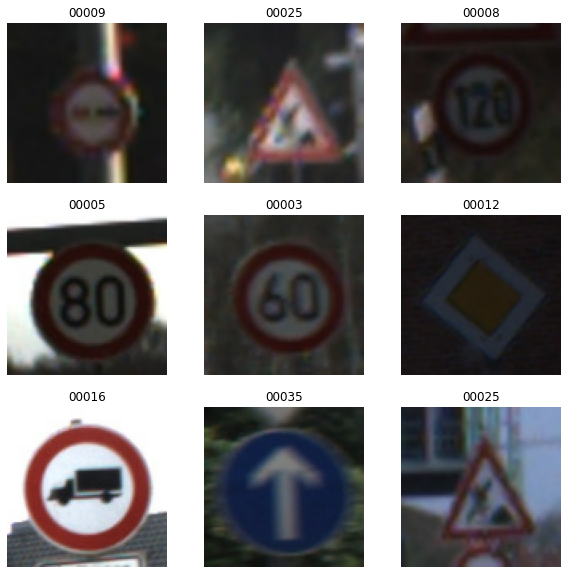

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 100, 100, 3)
(64,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
   #layers.GaussianNoise(0.2),
   layers.RandomRotation(0.08),
   layers.RandomZoom(0.1)
   #layers.RandomContrast(0.05)
   
  ]
)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(image_batch.shape)
model.summary()

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)



epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [tensorboard_callback]
)

Epoch 1/40
491/491 [==============================] - 362s 707ms/step - loss: 1.3542 - accuracy: 0.6089 - val_loss: 0.3319 - val_accuracy: 0.9115
Epoch 2/40
491/491 [==============================] - 343s 699ms/step - loss: 0.3051 - accuracy: 0.9125 - val_loss: 0.1241 - val_accuracy: 0.9665
Epoch 3/40
491/491 [==============================] - 343s 699ms/step - loss: 0.1563 - accuracy: 0.9557 - val_loss: 0.1038 - val_accuracy: 0.9704
Epoch 4/40
491/491 [==============================] - 365s 744ms/step - loss: 0.1094 - accuracy: 0.9688 - val_loss: 0.0655 - val_accuracy: 0.9858
Epoch 5/40
436/491 [=========================>....] - ETA: 36s - loss: 0.0847 - accuracy: 0.9753

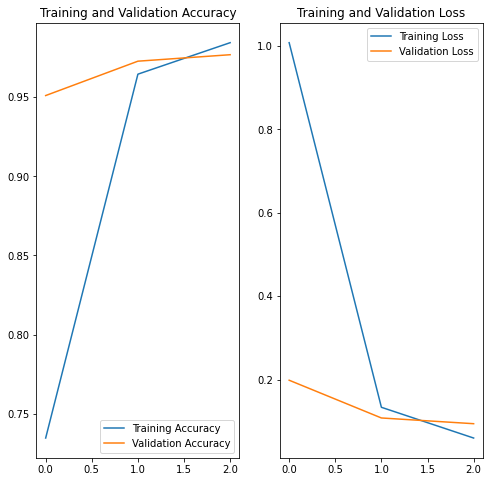

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
image_size = [img_height,img_width]

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  'test_partial/',
  labels = None,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = False)
probabilities = model.predict(test_ds)
predictions = [np.argmax(probas) for probas in probabilities]

Found 201 files belonging to 1 classes.


In [ ]:
#Now evaluate what we did
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix

test_classes = pd.read_csv('test_classes_partial.csv')
print(accuracy_score(test_classes.ClassId, predictions))
print(f1_score(test_classes.ClassId, predictions, average = 'weighted'))
print(f1_score(test_classes.ClassId, predictions, average = None))

0.8855721393034826
0.8828783019081526
[0.95238095 1.         0.88888889 0.875      0.83333333 0.85714286
 0.88888889 0.72727273 1.         1.         0.8        1.
 0.95238095 1.         1.         0.88888889 1.         0.61538462
 0.         0.66666667 1.         1.         0.         0.66666667
 0.78571429 0.85714286 1.         1.         0.8        0.28571429
 1.         1.         1.         0.66666667 1.         0.8
 1.         1.         1.        ]


In [ ]:
#Now let's visualize it
df_pred = pd.DataFrame(predictions, columns = ['predictions'])
df_pred.shape

(201, 1)

In [ ]:
overall = pd.concat([df_pred, test_classes], axis=1)
overall.head()

,predictions,Filename,ClassId
0,7,00000.jpg,16
1,5,00001.jpg,1
2,38,00002.jpg,38
3,33,00003.jpg,33
4,11,00004.jpg,11


In [ ]:
misses = overall[overall['predictions']!=overall['ClassId']]
misses.head()

,predictions,Filename,ClassId
0,7,00000.jpg,16
1,5,00001.jpg,1
12,19,00012.jpg,23
23,6,00023.jpg,3
33,19,00033.jpg,23


In [ ]:
print(f'We are at {misses.index.size/overall.index.size*100:.1f} % missed with the holdout dataset')

We are at 11.4 % missed with the holdout dataset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


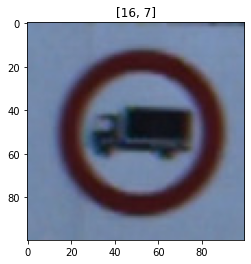

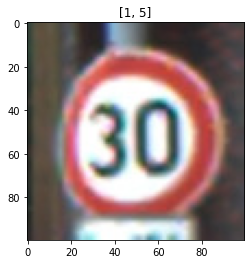

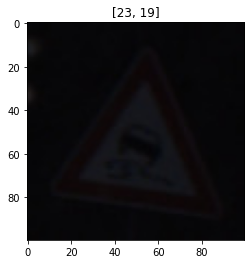

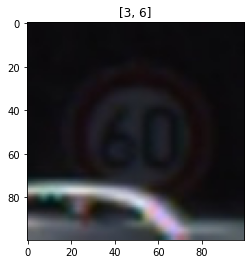

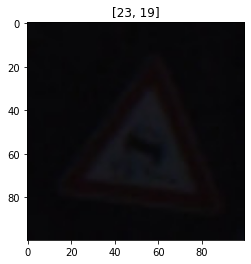

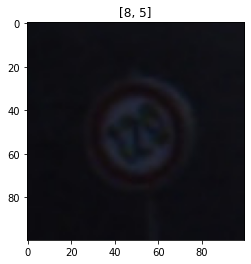

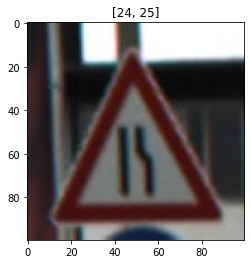

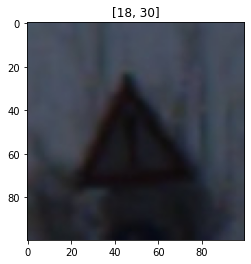

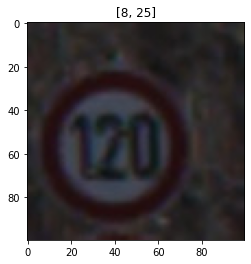

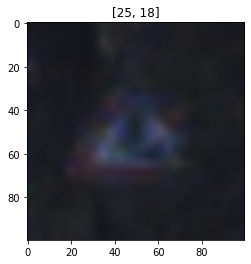

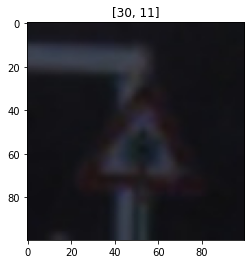

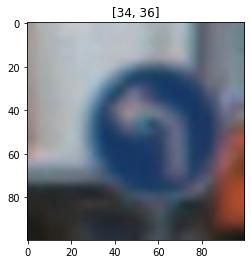

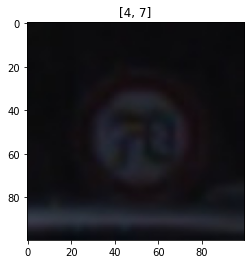

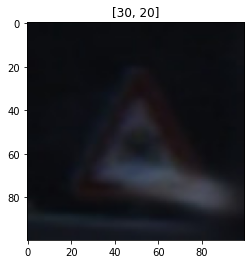

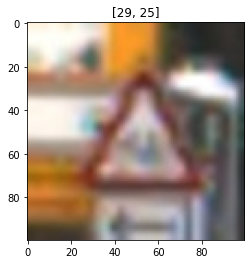

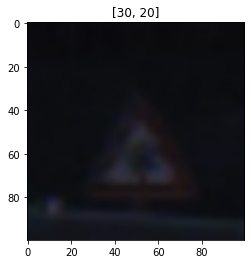

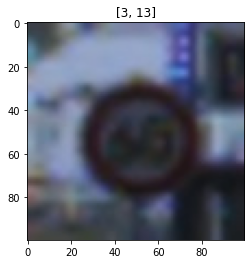

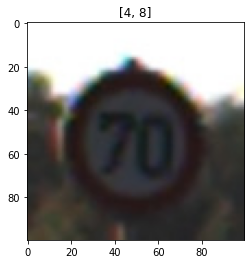

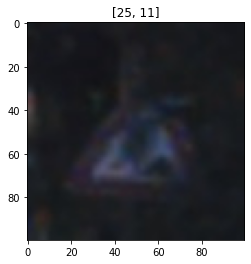

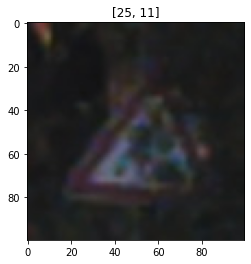

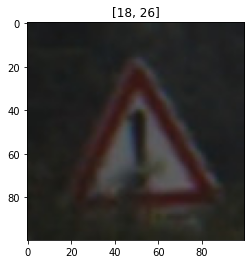

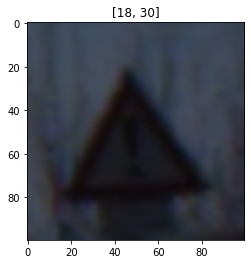

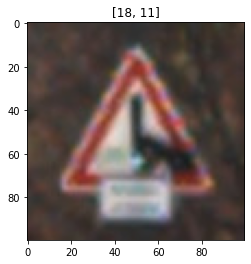

In [ ]:
miss_ids = misses.index.values
for miss in miss_ids:
  from keras.preprocessing.image import load_img
  pic = f'test/{miss:05}.jpg'
  img = load_img(pic, target_size=(100,100))
  plt.figure()
  plt.imshow(img)
  plt.title([misses.ClassId[miss], misses.predictions[miss]])

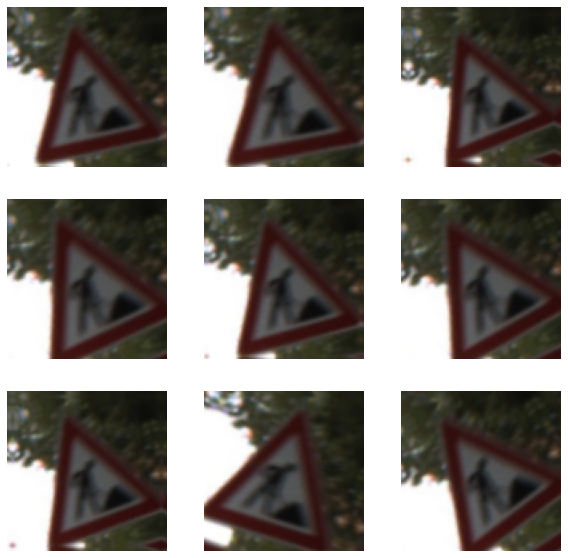

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
%load_ext tensorboard